In [ ]:
import pandas as pd
import seaborn as sns
import sys,os
sys.path.append(os.path.abspath(os.path.join("..")))
from config import *
from scipy.stats import mode
import numpy as np
import hdbscan
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc,classification_report
import matplotlib.pyplot as plt
from hdbscan import approximate_predict

In [45]:
df = pd.read_csv(vcf_path+"/GenotypeCounts.csv")
df.drop(columns=['patient_id','IL10RA','RELA','TAGAP','PTAFR','IL23R','SDF2L1','PTPN22','SLC39A8','HGFAC','DOK2','CCR7','LACC1','FUT2','ATG16L1'], inplace=True)  
labels = df['label']
X = df.drop(columns=['label'])  # Features (independent variables)
y = df['label']  # Target variable (dependent variable)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape}, Testing set size: {X_test.shape}")

Training set size: (88, 2), Testing set size: (23, 2)


/mnt/c/Users/Lenovo/Documents/project/capstone_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/mnt/c/Users/Lenovo/Documents/project/capstone_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Accuracy: 52.1739

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.55      0.92      0.69        13

    accuracy                           0.52        23
   macro avg       0.27      0.46      0.34        23
weighted avg       0.31      0.52      0.39        23



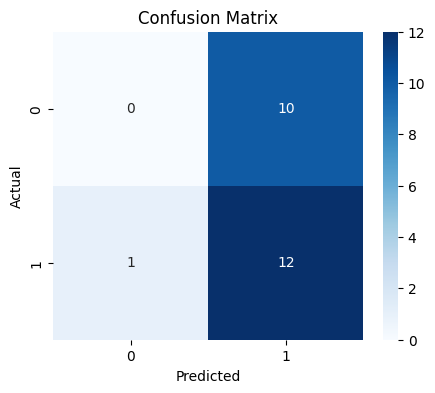

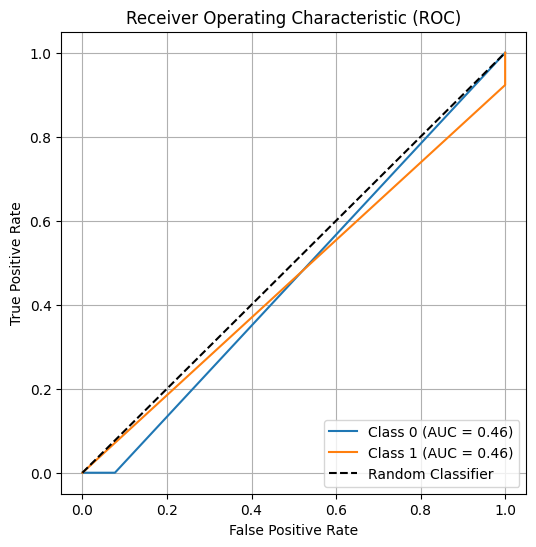

In [ ]:
HDBSCAN_clusters = hdbscan.HDBSCAN(min_cluster_size=4, min_samples=1, metric='hamming', prediction_data=True)
HDBSCAN_clusters.fit(X_train)
# Assign each cluster to the majority label in the training set
cluster_to_label = {}
unique_clusters = np.unique(HDBSCAN_clusters.labels_)
for cluster in unique_clusters:
    mask = HDBSCAN_clusters.labels_ == cluster
    majority_label = mode(y_train[mask]).mode
    if isinstance(majority_label, np.ndarray):
        majority_label = majority_label[0]  # Access the first element if it's an array
    cluster_to_label[cluster] = majority_label

# Use the approximate_predict function from the hdbscan module
predicted_clusters, strengths = approximate_predict(HDBSCAN_clusters, X_test)
# Convert clusters to class labels (use mode of cluster if assigned, -1 if noise)
predicted_labels = np.array([cluster_to_label.get(cluster, -1) for cluster in predicted_clusters])

# Compute accuracy
accuracy = accuracy_score(y_test, predicted_labels)
print(f"Accuracy: {accuracy * 100:.4f}")

# Classification Report

print("\nClassification Report:\n", classification_report(y_test, predicted_labels))

# Confusion Matrix
cm = confusion_matrix(y_test, predicted_labels)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Plot ROC Curve
# Assuming a multi-class scenario, we need to convert to a one-vs-rest approach
# Create a one-vs-rest binary indicator for each class
plt.figure(figsize=(6, 6))
for class_id in np.unique(y_test):
    y_true_binary = (y_test == class_id).astype(int)
    y_pred_binary = (predicted_labels == class_id).astype(int)
    fpr, tpr, _ = roc_curve(y_true_binary, y_pred_binary)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_id} (AUC = {roc_auc:.2f})')

# Plot the random classifier line
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [268]:
df.columns

Index(['NOD2', 'CARD9'], dtype='object')

In [ ]:
df.drop(columns=['patient_id','IL10RA','RELA','TAGAP','PTAFR','IL23R','SDF2L1','PTPN22','SLC39A8','HGFAC','DOK2','CCR7','LACC1','FUT2','CARD9','ATG16L1','label'], inplace=True)  
for i in metrics:
    # Perform HDBSCAN clustering
    HDBSCAN_clusters = hdbscan.HDBSCAN(min_cluster_size=19,min_samples=1, metric=i).fit_predict(df)
    # Create a DataFrame to hold the cluster assignments
    cluster_data = pd.DataFrame({'Cluster': HDBSCAN_clusters, 'Label': labels})
    # Count occurrences of each label in each cluster
    cluster_counts = cluster_data.groupby(['Cluster', 'Label']).size().unstack(fill_value=0)
    # Plot stacked histogram
    plt.figure(figsize=(7, 7))
    bar1 = plt.bar(cluster_counts.index, cluster_counts[0], color='blue', label='Label 0')
    bar2 = plt.bar(cluster_counts.index, cluster_counts[1], bottom=cluster_counts[0], color='red', label='Label 1')
    plt.xticks(cluster_counts.index)
    plt.legend()
    # Annotate bars
    for bar in bar1 + bar2:
        yval = bar.get_height()
        if yval > 0:
            plt.text(bar.get_x(), bar.get_y() + yval / 2, int(yval), ha='center', va='center', fontsize=10, color='black')
    plt.title(f'Stacked Histogram for Metric: {i}')
    plt.show()